# Supplement Figure --- Mn model summary; panel of transect observations and model concentrations

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import netCDF4 as nc
import cmocean
import pandas as pd 
import pickle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0,'../paper1/figures/')
import modules.mapping_functions as mf
import glob
import xarray as xr
from datetime import datetime

%matplotlib inline

#### Parameters:

In [10]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# model results:
results_folder = f'/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-2015_20220422/'

# colours:
land_color = '#a9a7a2'

#### Load files:

In [11]:
# ANHA12 grid
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_hdept = np.array(mesh.variables['hdept'][0,imin:imax,jmin:jmax])

In [12]:
# Load model data structure
Mn_model     = nc.Dataset(f'{results_folder}ANHA12_EXH006_2015_monthly.nc')
lat_model    = np.array(Mn_model.variables['nav_lat'])
lon_model    = np.array(Mn_model.variables['nav_lon'])
depths_model = np.array(Mn_model.variables['deptht'])

Observations

In [13]:
# 2015 GEOTRACES dataset:
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float')
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float')

GEOTRACES_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES_data['Station names'].dropna().astype('str')
lons      = GEOTRACES_data['station lon'].astype('float').dropna().values
lats      = GEOTRACES_data['Station lat'].astype('float').dropna().values

#### Functions:

In [14]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    start_date_2015 = datetime.strptime(f'2015-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2015-09-15', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dmn_2015 = np.zeros((50,700,640))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dmn_2015 = dmn_2015 + ds['dissolmn'].values[0,:,:,:]

    mn_dis_ref_2015 = dmn_2015 / len(file_list_2015)
    
    return mn_dis_ref_2015

In [15]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = np.array(input_var)[i]
        else:
            vector[i] = np.nan
    return vector

In [16]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

Load model data:

In [17]:
dmn_2015 = calculate_average(results_folder)

#### Figure of transect along stations:

In [18]:
# Gather data from observed stations and calculate distance from CB4 for each station:
transect_names       = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3']
transect_lons        = np.array([]); transect_lats   = np.array([]);
transect_dMn         = np.zeros((24,len(transect_names)))
transect_depths      = np.zeros((24,len(transect_names)))
transect_distances   = np.zeros(len(transect_names))
for k,name in enumerate(transect_names):
    transect_lons = np.append(transect_lons, lons[stn_names==name])
    transect_lats = np.append(transect_lats, lats[stn_names==name])
    
    transect_distances[k] = mf.haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    transect_dMn[:,k]     = fill_nans(Manuel_dMn_nmolL[Manuel_station_names==name].values)
    transect_depths[:,k]  = fill_nans(Manuel_depths[Manuel_station_names==name].values)
    
transect_depths_r = transect_depths[::-1, :] #reversed order so that surface points are stacked on top
transect_dMn_r    = transect_dMn[::-1, :] 

In [19]:
# Now, create vectors of many points along the line connecting these stations:
transect_vector_lons = np.array([])
transect_vector_lats = np.array([])
for i in range(0,len(transect_lons)-1):
    # Longitude change between the two stations:
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    # Increment from previous station to next over this longitude change: 
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,300)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,300)
    # Create an array of associated longitudes and latitudes:
    transect_vector_lons = np.append(transect_vector_lons, vector_lons)
    transect_vector_lats = np.append(transect_vector_lats, vector_lats)

In [20]:
# Find Mn model grid point coordinates associated with the array of points:
transect_i, transect_j = mf.find_indeces_vector(transect_vector_lons, transect_vector_lats, lon_model, lat_model)

transect_model_distances = np.array([])
transect_model_hdept     = np.array([])
transect_dissolved_mn    = np.zeros((len(depths_model), len(transect_vector_lons)))
# Gather model results and bathymetry for the array of points
for n in range(0,len(transect_vector_lons)):
    distance_model = mf.haversine(lon_model[int(transect_i[0]), int(transect_j[0])],\
                                  lat_model[int(transect_i[0]), int(transect_j[0])],\
                                  lon_model[int(transect_i[n]), int(transect_j[n])],\
                                  lat_model[int(transect_i[n]), int(transect_j[n])])
    transect_model_distances = np.append(transect_model_distances, distance_model)
    transect_model_hdept     = np.append(transect_model_hdept, mesh_hdept[int(transect_i[n]), int(transect_j[n])])
    
    transect_dissolved_mn[:,n] = dmn_2015[:,int(transect_i[n]), int(transect_j[n])]

In [21]:
# Station name labels:
transect_names2     = list(np.copy(transect_names))
transect_names2[5]  = 'CAA6,7'
transect_names2[6]  = ''
transect_names2[7]  = 'CAA4,5'
transect_names2[8]  = ''
transect_names2[9]  = 'CAA1,2,3'
transect_names2[10] = ''
transect_names2[11] = ''

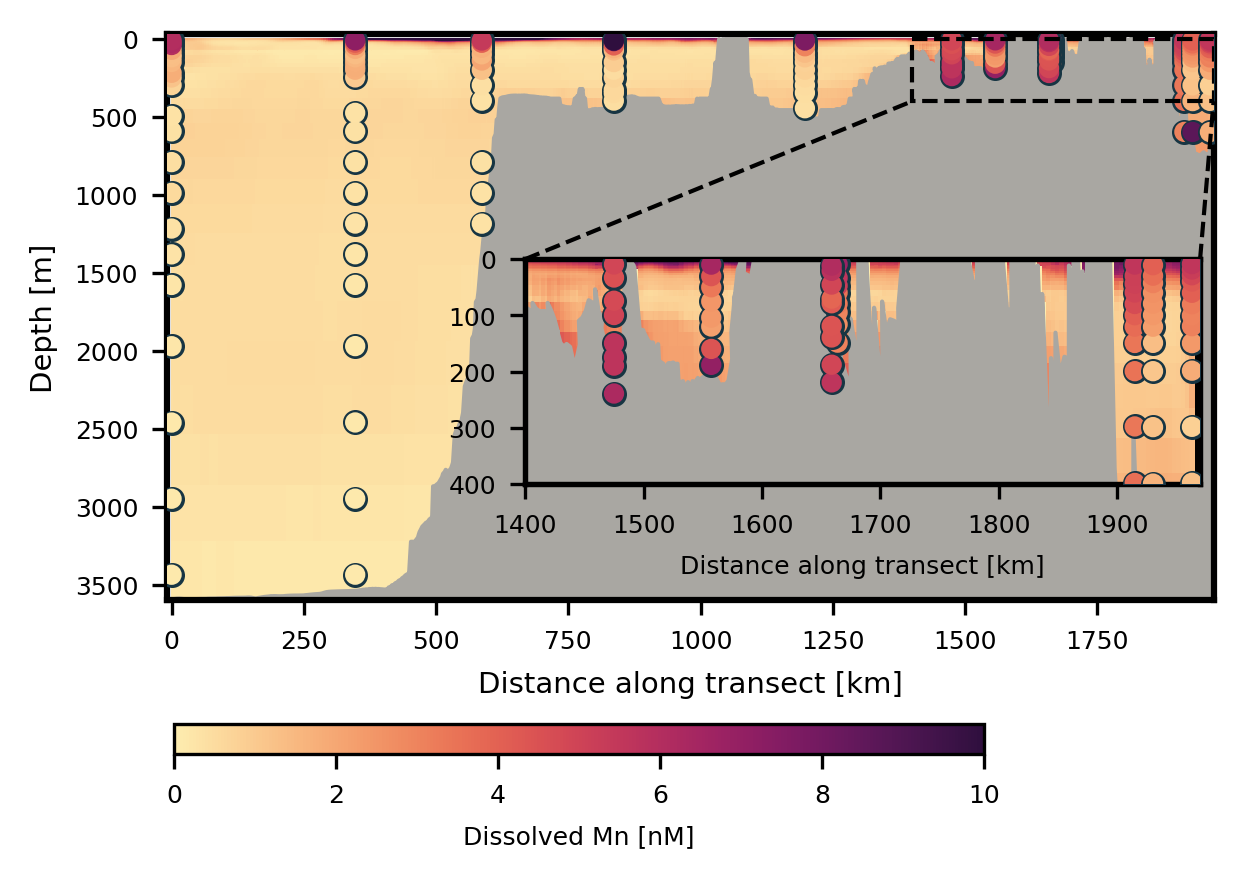

In [34]:
fig, ax = plt.subplots(1,1, figsize=(4.5, 2.5), dpi=300)

# limits for colorbar:
vminmn = 0 
vmaxmn = 10
pointsbg = '#173543'# outline color for scatterpoints

# Full scale transect: -----------------------------------------------------------------------
for i in range(0,len(transect_lons)):
    ax.scatter(transect_distances[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=25)
    sc = ax.scatter(transect_distances[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.matter,\
                       zorder = 3, s=15)
    
ax.invert_yaxis()
contour = ax.pcolormesh(transect_model_distances, depths_model, transect_dissolved_mn*10**(9), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.matter)
ax.fill_between(transect_model_distances, 4000, transect_model_hdept, color=land_color, zorder=1)
ax.set_ylabel('Depth [m]', fontsize=7)
ax.set_xlabel('Distance along transect [km]', fontsize=7)
ax.set_ylim([3600, -30])
ax.set_xlim([-8, 1970])
ax.tick_params(axis='both', which='major', labelsize=6)
plt.setp(ax.spines.values(), linewidth=1.5, color='k')

# Zoom in of shallow area(inset axes): ---------------------------------------------------------
inset_ax = fig.add_axes([.39, .28, .5, .3], facecolor='k')
for i in range(0,len(transect_lons)):
    inset_ax.scatter(transect_distances[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=25)
    sc = inset_ax.scatter(transect_distances[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.matter,\
                       zorder = 3, s=15)

inset_ax.invert_yaxis()
inset_ax.set_ylim([400, 0])
inset_ax.set_xlim([1400, 1970])
inset_ax.set_xlabel('Distance along transect [km]', fontsize=6)
inset_ax.pcolormesh(transect_model_distances, depths_model, transect_dissolved_mn*1e9, \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.matter)
inset_ax.fill_between(transect_model_distances, 3500, transect_model_hdept, color=land_color, zorder=1)
inset_ax.tick_params(axis='both', which='major', labelsize=6)
plt.setp(inset_ax.spines.values(), linewidth=1.3, color='k')

# General plot settings ------------------------------------------------
# Colorbar:
cbar_ax = fig.add_axes([0.13, -0.08, 0.6, 0.04])
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Dissolved Mn [nM]', fontsize=6) 
cbar_ax.tick_params(axis='both', which='major', labelsize=6)
# Mark inset:
mark_inset(ax, inset_ax, loc1=2, loc2=1, fc="none", ec='k', lw=1.0, linestyle='--', zorder=4);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S1-transect.jpg', \
               bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S1-transect.svg', \
               bbox_inches='tight', dpi=300, format='svg')